In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
 data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
import numpy as np
temperature = np.zeros(len(lines),)
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i:] = values[:]

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()
plt.plot(range(1440), temperature[:1440])

In [ ]:
# define a number train, val, test dataset
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_train_samples

# Normalizing the data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
# Instantiating datasets for training, validation, and testing
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 -1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples,
 end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=temperature[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples + num_val_samples)


In [ ]:
# Compute the common-sense baseline MAE

def evaluate_naive_method(dataset):
 total_abs_err = 0.
 samples_seen = 0
 for samples, targets in dataset:
 preds = samples[:, -1, 1] * std[1] + mean[1]
 total_abs_err += np.sum(np.abs(preds - targets))
 samples_seen += samples.shape[0]
 return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

IndentationError: ignored

In [ ]:
from tensorflow.python.module.module import valid_identifier
# Training and evaluating a densely connected model

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 42s 48ms/step - loss: 11.8469 - mae: 2.6683 - val_loss: 11.7233 - val_mae: 2.6950
Epoch 2/10
819/819 [==============================] - 38s 46ms/step - loss: 8.7941 - mae: 2.3314 - val_loss: 10.1531 - val_mae: 2.5036
Epoch 3/10
819/819 [==============================] - 38s 46ms/step - loss: 8.1036 - mae: 2.2360 - val_loss: 10.5561 - val_mae: 2.5612
Epoch 4/10
819/819 [==============================] - 39s 47ms/step - loss: 7.6788 - mae: 2.1760 - val_loss: 10.3065 - val_mae: 2.5185
Epoch 5/10
819/819 [==============================] - 38s 47ms/step - loss: 7.3880 - mae: 2.1348 - val_loss: 10.5079 - val_mae: 2.5410
Epoch 6/10
819/819 [==============================] - 38s 46ms/step - loss: 7.2065 - mae: 2.1076 - val_loss: 11.1470 - val_mae: 2.6287
Epoch 7/10
819/819 [==============================] - 38s 46ms/step - loss: 7.0212 - mae: 2.0814 - val_loss: 10.7742 - val_mae: 2.5690
Epoch 8/10
819/819 [==============================] - 

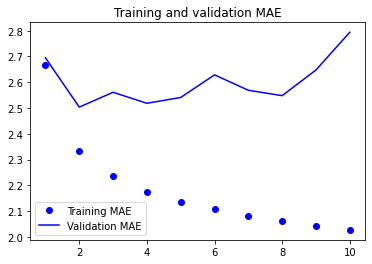

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
# use Conv1D and maxpooling for layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_conv.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 47s 49ms/step - loss: 22.7086 - mae: 3.7513 - val_loss: 16.6762 - val_mae: 3.2632
Epoch 2/10
819/819 [==============================] - 40s 49ms/step - loss: 15.9681 - mae: 3.1748 - val_loss: 16.9935 - val_mae: 3.2421
Epoch 3/10
819/819 [==============================] - 40s 48ms/step - loss: 14.4462 - mae: 3.0107 - val_loss: 15.6569 - val_mae: 3.1476
Epoch 4/10
819/819 [==============================] - 40s 48ms/step - loss: 13.5934 - mae: 2.9186 - val_loss: 14.7425 - val_mae: 3.0341
Epoch 5/10
819/819 [==============================] - 40s 49ms/step - loss: 12.9501 - mae: 2.8427 - val_loss: 14.9592 - val_mae: 3.0484
Epoch 6/10
819/819 [==============================] - 41s 49ms/step - loss: 12.4787 - mae: 2.7922 - val_loss: 14.4913 - val_mae: 2.9914
Epoch 7/10
819/819 [==============================] - 40s 48ms/step - loss: 12.0760 - mae: 2.7473 - val_loss: 15.5891 - val_mae: 3.1233
Epoch 8/10
819/819 [============================

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
# Use Long Sort Term Memory (LSTM)
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_lstm.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 46s 53ms/step - loss: 40.0879 - mae: 4.6010 - val_loss: 12.2592 - val_mae: 2.6734
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 11.0932 - mae: 2.5831 - val_loss: 9.9019 - val_mae: 2.4439
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 9.9374 - mae: 2.4544 - val_loss: 9.6610 - val_mae: 2.4041
Epoch 4/10
819/819 [==============================] - 43s 52ms/step - loss: 9.5004 - mae: 2.3982 - val_loss: 9.5100 - val_mae: 2.3844
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 9.2485 - mae: 2.3632 - val_loss: 9.6336 - val_mae: 2.3953
Epoch 6/10
819/819 [==============================] - 44s 53ms/step - loss: 9.0162 - mae: 2.3293 - val_loss: 10.0067 - val_mae: 2.4326
Epoch 7/10
819/819 [==============================] - 42s 52ms/step - loss: 8.8471 - mae: 2.3028 - val_loss: 10.3906 - val_mae: 2.4710
Epoch 8/10
819/819 [==============================] - 42s